
# TOPTW

This notebook is meant as a starter for the assignment. It **reads the classic TOPTW test instance format** (as used by the Righini & Salani set) and provides:
- Clear documentation of the file structure.
- A robust parser for the variable-length lines.
- Helpers to build distance/time matrices with the **rounding-down rule** used in the literature.
- A recap of the **mathematical model** (hard vs soft time windows) you will optimize.
- Pointer to the **benchmark instances**.

> Benchmark hub (TOP / TOPTW): **KU Leuven CIB**  
> https://www.mech.kuleuven.be/en/cib/op#autotoc-item-autotoc-6



## File format

Headers:
```
k v N t
D Q      # Note: D is often missing; sometimes you only see one number (Q)
```

Node lines (including depot 0):
```
i  x  y  d  S  f  a  (list of length a)  O  C
```
- `i` = point index, **0 is the depot** (start & end)
- `x, y` = coordinates
- `d` = service duration
- `S` = profit if visited
- `f, a, list` = not used (kept for completeness)
- `O, C` = time window open/close (earliest/latest start of service)

**Remarks**
- The number of routes (**P**) is **not in the file** (you decide it, or optimise it).
- Per-route time budget **Tmax = depot C**.
- Distances are Euclidean and traditionally **rounded down**: 1 decimal (Solomon) or 2 decimals (Cordeau).



## Mathematical model (TOPTW) — hard & soft time windows

Let the depot be node $0$, customers $V=\{1,\dots,n\}$, and vehicles $k=1,\dots,K$.
Let $d_{ij}$ be distances and $t_{ij}$ travel times (assume $t_{ij}=d_{ij}$), $q_i$ demand (0 if not used), $s_i$ service time,
$[a_i,b_i]$ time window, and $p_i$ profit. Capacity $Q$, optional fixed cost $f$ per vehicle, lateness penalty $\beta\ge 0$.
Big-$M$ constants $M_t,M_q$ deactivate time/load propagation on unused arcs.

**Decision variables**
- $x_{ijk}\in\{0,1\}$: arc $(i\to j)$ is used by vehicle $k$ (with $i\neq j$).
- $y_i\in\{0,1\}$: customer $i$ is served.
- $u_k\in\{0,1\}$: vehicle $k$ is used.
- $t_i\ge 0$: service start time at node $(i)$.
- $w_i\ge 0$: load after serving $(i)$.
- (**soft-TW only**) $L_i\ge 0$: lateness at $i$.

**Objective (hard time windows)**
$$
\max \sum_{i\in V} p_i y_i - \sum_{k=1}^K \sum_{\substack{i,j\in\{0\}\cup V\\ i\ne j}} d_{ij} x_{ijk} - f\sum_{k=1}^K u_k.
$$

**Objective (soft time windows)**
$$
\max \sum_{i\in V} p_i y_i - \sum_{k=1}^K \sum_{\substack{i,j\in\{0\}\cup V\\ i\ne j}} d_{ij} x_{ijk} - f\sum_{k=1}^K u_k - \beta \sum_{i\in V} L_i.
$$

**Constraints**
- Vehicle usage and depot degree (per vehicle):
$$
\sum_{j\in V} x_{0jk}=\sum_{i\in V} x_{i0k}=u_k \quad \forall k.
$$
- Visit equals served (flow over all vehicles):
$$
\sum_{j\in\{0\}\cup V}\sum_{k=1}^K x_{ijk}=\sum_{j\in\{0\}\cup V}\sum_{k=1}^K x_{jik}=y_i \quad \forall i\in V.
$$
- Capacity propagation (optional if no capacity is modeled):
$$
w_j \ge w_i + q_j - M_q\!\left(1-\sum_{k=1}^K x_{ijk}\right),\qquad 0\le w_i \le Q\,y_i.
$$
- Time propagation:
$$
t_j \ge t_i + s_i + t_{ij} - M_t\!\left(1-\sum_{k=1}^K x_{ijk}\right).
$$
- Time windows (choose one policy):
  - **Hard TW**: $a_i \le t_i \le b_i + M_t(1-y_i)$.
  - **Soft TW**: $a_i \le t_i \le b_i + L_i + M_t(1-y_i), \; L_i\ge 0$.
- Optional route duration per vehicle $k$: $t^{\text{return},k}_0 \le t^{\text{start},k}_0 + T_{\max}$.

*This compact VRPTW-style formulation is the one used in the assignment.*



## Parser implementation (robust to the variable-length `list`)

The parser below:
- Skips comment lines starting with `*`.
- Supports the second header line being either `D Q` or just `Q`.
- Reads the `a` field and consumes exactly `a` entries for the list before reading `O` and `C`.
- Stores everything in convenient Python data classes.
- Provides a helper to build $d_{ij}$ and $t_{ij}$ with the rounding-down convention.


In [15]:
from dataclasses import dataclass
from typing import List, Optional, Tuple
import math, re, pathlib

@dataclass
class TOPTWNode:
    i: int
    x: float
    y: float
    service: float   # d
    profit: float    # S
    tw_open: float   # O
    tw_close: float  # C
    f: int           # not relevant (kept for completeness)
    a: int           # 'a' value; the length of aux_list
    aux_list: List[int]  # variable-length list after 'a'

@dataclass
class TOPTWInstance:
    path: str
    k: int
    v: int
    N: int
    t: int
    D: Optional[float]
    Q: Optional[float]
    Tmax: float                # equals depot.tw_close
    nodes: List[TOPTWNode]     # length N+1 (0..N)

def _floor_to_decimals(x: float, decimals: int) -> float:
    if decimals is None:
        return float(x)
    f = 10 ** decimals
    return math.floor(x * f) / f

def _auto_rounding_decimals_from_name(path: str) -> int:
    # c101, r201, rc2xx -> Solomon (1 decimal); else Cordeau (2 decimals)
    name = pathlib.Path(path).name.lower()
    if re.search(r'(?:^|_)((c|r|rc)\d+)', name):
        return 1
    return 2

def build_distance_time_matrices(inst: TOPTWInstance,
                                 speed: float = 1.0,
                                 rounding: str = "auto"  # "auto"|"solomon"|"cordeau"|"none"
                                 ) -> Tuple[List[List[float]], List[List[float]]]:
    pts = [(n.x, n.y) for n in inst.nodes]
    n = len(pts)
    if rounding == "auto":
        dec = _auto_rounding_decimals_from_name(inst.path)
    elif rounding == "solomon":
        dec = 1
    elif rounding == "cordeau":
        dec = 2
    else:
        dec = None

    def euclid(a, b): return math.hypot(a[0]-b[0], a[1]-b[1])

    dist = [[0.0]*n for _ in range(n)]
    tmat = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                d = 0.0
            else:
                d = euclid(pts[i], pts[j])
                d = _floor_to_decimals(d, dec)
            dist[i][j] = d
            tmat[i][j] = d / speed if speed > 0 else d
    return dist, tmat

def parse_toptw_instance(path: str) -> TOPTWInstance:
    path = str(path)
    with open(path, "r", encoding="utf-8") as f:
        raw_lines = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("*")]

    # Header 1: k v N t
    k, v, N, t = map(int, raw_lines[0].split())

    # Header 2: "D Q" or just "Q"
    hdr2 = raw_lines[1].split()
    if len(hdr2) >= 2:
        D = float(hdr2[0])
        Q = float(hdr2[1])
    elif len(hdr2) == 1:
        D = None
        Q = float(hdr2[0])
    else:
        D = None
        Q = None

    # Node lines: expect N+1, including depot 0
    nodes: List[TOPTWNode] = []
    expected = N + 1
    lines = raw_lines[2:2+expected]

    for ln in lines:
        toks = ln.split()
        # Fixed part
        i = int(toks[0])
        x = float(toks[1]); y = float(toks[2])
        d = float(toks[3])     # service
        S = float(toks[4])     # profit
        f = int(float(toks[5]))
        a = int(float(toks[6]))

        pos_after_list = 7 + a
        if len(toks) >= pos_after_list + 2:
            aux = [int(float(t)) for t in toks[7:7+a]] if a > 0 else []
            O = float(toks[pos_after_list])
            C = float(toks[pos_after_list + 1])
        else:
            # Fallback: treat last two as O,C; anything in between as aux
            O = float(toks[-2]); C = float(toks[-1])
            aux = [int(float(t)) for t in toks[7:-2]] if len(toks) > 9 else []

        nodes.append(TOPTWNode(
            i=i, x=x, y=y, service=d, profit=S,
            tw_open=O, tw_close=C, f=f, a=a, aux_list=aux
        ))

    Tmax = nodes[0].tw_close  # per format
    return TOPTWInstance(path=path, k=k, v=v, N=N, t=t, D=D, Q=Q, Tmax=Tmax, nodes=nodes)



## Demo: load a Righini & Salani instance

If you have a file locally, set `PATH_TO_FILE` accordingly. This cell tries to load `/mnt/data/50_c102.txt` (provided in this environment).


In [16]:
import os, pandas as pd

DEFAULT_PATH = r"C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks\benchmarks\50_c102.txt"
PATH_TO_FILE = DEFAULT_PATH if os.path.exists(DEFAULT_PATH) else "file not found"

if PATH_TO_FILE:
    inst = parse_toptw_instance(PATH_TO_FILE)
    print(f"Loaded: {inst.path}")
    print(f"k={inst.k}, v={inst.v}, N={inst.N}, t={inst.t}, D={inst.D}, Q={inst.Q}, Tmax={inst.Tmax}")
    df_nodes = pd.DataFrame([{
        "i":n.i,"x":n.x,"y":n.y,"service":n.service,"profit":n.profit,
        "O":n.tw_open,"C":n.tw_close,"a":n.a,"aux_len":len(n.aux_list)
    } for n in inst.nodes])
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("TOPTW nodes (preview)", df_nodes.head(12))
    except Exception:
        display(df_nodes.head(12))
else:
    print("Please set PATH_TO_FILE to the path of your Righini & Salani TOPTW .txt file.")


Loaded: C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks\benchmarks\50_c102.txt
k=4, v=10, N=50, t=1, D=0.0, Q=200.0, Tmax=1236.0


,i,x,y,service,profit,O,C,a,aux_len
0,0,40.0,50.0,0.0,0.0,0.0,1236.0,0,0
1,1,45.0,68.0,90.0,10.0,0.0,1127.0,1,1
2,2,45.0,70.0,90.0,30.0,0.0,1125.0,1,1
3,3,42.0,66.0,90.0,10.0,0.0,1129.0,1,1
4,4,42.0,68.0,90.0,10.0,727.0,782.0,1,1
5,5,42.0,65.0,90.0,10.0,0.0,1130.0,1,1
6,6,40.0,69.0,90.0,20.0,621.0,702.0,1,1
7,7,40.0,66.0,90.0,20.0,0.0,1130.0,1,1
8,8,38.0,68.0,90.0,20.0,255.0,324.0,1,1
9,9,38.0,70.0,90.0,10.0,534.0,605.0,1,1



## Distance & time matrices (with rounding) and a quick scatter plot


Distance matrix shape: (51, 51)
Example distances from depot (node 0) to first 5 nodes: [0.0, 18.6, 20.6, 16.1, 18.1, 15.1]


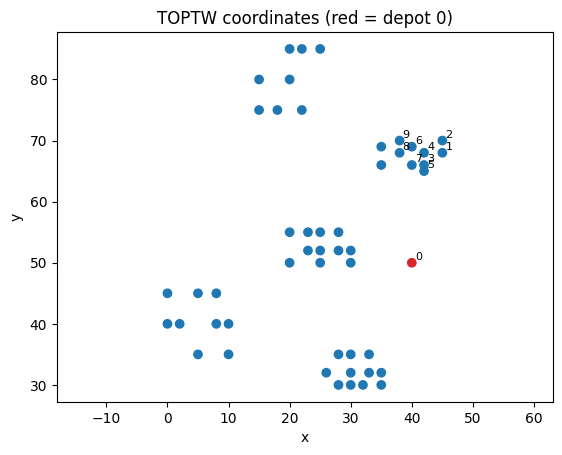

In [17]:
import matplotlib.pyplot as plt
import numpy as np

if PATH_TO_FILE:
    dist, tmat = build_distance_time_matrices(inst, rounding="auto")
    print("Distance matrix shape:", (len(dist), len(dist)))
    print("Example distances from depot (node 0) to first 5 nodes:", dist[0][:6])

    xs = [n.x for n in inst.nodes]
    ys = [n.y for n in inst.nodes]
    colors = ["tab:red" if n.i==0 else "tab:blue" for n in inst.nodes]
    plt.figure()
    plt.scatter(xs, ys, c=colors)
    for n in inst.nodes[:10]:  # annotate a few
        plt.text(n.x+0.5, n.y+0.5, str(n.i), fontsize=8)
    plt.title("TOPTW coordinates (red = depot 0)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.axis("equal")
    plt.show()



# Capacitated TOPTW Extension

This section augments the classic **TOPTW (Team Orienteering Problem with Time Windows)** data with **vehicle capacity** information.

We add:

1. A `demand` for every customer node.
2. A vehicle capacity `Q` (interpreted as per-vehicle capacity).
3. Utilities to:
   - generate random demands,
   - choose a consistent capacity,
   - export enriched instances to JSON,
   - reload those JSON instances later.

The goal is to be able to treat the instance as a capacitated prize-collecting VRPTW / TOPTW-with-capacity.


In [18]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class TOPTWNode:
    i: int
    x: float
    y: float
    service: float    # service duration
    profit: float     # profit / score
    tw_open: float    # earliest service time
    tw_close: float   # latest service time
    f: int            # extra field from original format
    a: int            # length of aux_list in original file
    aux_list: List[int]
    demand: int = 0   # NEW: demand of this node (0 for depot)

@dataclass
class TOPTWInstance:
    path: str
    k: int            # number of vehicles / routes allowed
    v: int            # carried over from source format
    N: int            # number of customers (excl. depot)
    t: int            # carried over from source format
    D: Optional[float]
    Q: Optional[float]   # vehicle capacity we'll assign
    Tmax: float          # usually depot.tw_close in source data
    nodes: List[TOPTWNode]



## Demand generation

We assign integer `demand` values to non-depot nodes (1..N). The depot (0) keeps demand 0.

We provide three strategies via `mode`:
- `independent`: random in `[lo, hi]` (uniform integers).
- `correlate_profit`: higher profit ⇒ higher demand.
- `depot_distance`: farther from depot ⇒ higher demand.

All strategies return a list `demands` of length `N+1`.


In [19]:
import math
import numpy as np
from typing import Tuple, List

def generate_demands(
    inst: TOPTWInstance,
    mode: str = "independent",
    rng: np.random.Generator | None = None,
    demand_range: Tuple[int, int] = (1,10)
) -> List[int]:
    """
    Create integer demands for each node of a TOPTWInstance.
    Index 0 (depot) always gets demand 0.

    mode:
      - 'independent': uniform integer in [lo,hi]
      - 'correlate_profit': scale profit to [lo,hi]
      - 'depot_distance': scale euclidean distance-from-depot to [lo,hi]
    """
    lo, hi = demand_range
    n_total = inst.N + 1

    if rng is None:
        rng = np.random.default_rng()

    demands = [0]*n_total  # depot = 0

    if inst.N == 0:
        return demands

    if mode == "independent":
        demands[1:] = rng.integers(lo, hi+1, size=inst.N).tolist()

    elif mode == "correlate_profit":
        profits = [n.profit for n in inst.nodes]
        min_p = min(profits[1:])
        max_p = max(profits[1:])
        if max_p == min_p:
            demands[1:] = [ (lo+hi)//2 ]*inst.N
        else:
            for idx in range(1,n_total):
                p = inst.nodes[idx].profit
                scaled = lo + (p-min_p)*(hi-lo)/(max_p-min_p)
                d_int = int(round(scaled))
                d_int = max(lo, min(hi, d_int))
                demands[idx] = d_int

    elif mode == "depot_distance":
        x0,y0 = inst.nodes[0].x, inst.nodes[0].y
        dists = [0.0]*n_total
        for idx in range(1,n_total):
            n = inst.nodes[idx]
            dists[idx] = math.hypot(n.x-x0, n.y-y0)
        min_d = min(dists[1:])
        max_d = max(dists[1:])
        if max_d == min_d:
            demands[1:] = [ (lo+hi)//2 ]*inst.N
        else:
            for idx in range(1,n_total):
                dd = dists[idx]
                scaled = lo + (dd-min_d)*(hi-lo)/(max_d-min_d)
                d_int = int(round(scaled))
                d_int = max(lo, min(hi, d_int))
                demands[idx] = d_int
    else:
        raise ValueError(f"Unknown mode: {mode}")

    return demands



## Choosing a vehicle capacity `Q`

We want capacity to actually matter: total fleet capacity should be *less* than the sum of all customer demand.

Let:
- `K` = number of vehicles.
- `demands` = list of node demands.
- `Q_ratio` = fraction (e.g. 0.25) of total demand that all vehicles combined are allowed to carry.

We set:

\[
Q \approx \left\lfloor \frac{Q\_ratio \cdot \sum_{i>0} q_i}{K} \right\rfloor
\]

and then clamp `Q` so it's at least the largest single-customer demand.


In [20]:
def choose_capacity(demands: List[int], K: int, Q_ratio: float = 0.25) -> int:
    """Pick per-vehicle capacity Q.

    We try to enforce that K*Q ~= Q_ratio * total_demand, so
    capacity becomes binding. We also ensure that Q is at least
    each single customer's demand so serving one node is feasible.
    """
    total_demand = sum(demands[1:])  # ignore depot
    if total_demand <= 0:
        return 0

    target_combined = Q_ratio * total_demand
    if target_combined < 1:
        target_combined = 1

    if K > 0:
        Q = math.floor(target_combined / K)
    else:
        Q = math.floor(target_combined)

    if Q < 1:
        Q = 1

    max_single = max(demands[1:]) if len(demands) > 1 else 0
    if Q < max_single:
        Q = max_single

    return int(Q)



## Exporting a capacitated instance to JSON

We now define a helper that takes:
- the parsed TOPTW instance (without demands),
- a chosen number of vehicles `K`,
- demand generation strategy and parameters,

and writes out an easy-to-read JSON file with:
- all meta fields (`k`, `N`, `Tmax`, ...),
- `Q` (vehicle capacity),
- a full node list including `demand`.

We'll also add a loader to bring that JSON back into the dataclasses.


In [21]:
import os, json, glob
import pathlib

def convert_to_capacitated_json(
    inst_paths,
    out_dir: str = "benchmarks_cap_json",
    K: int | None = None,
    demand_mode: str = "independent",
    demand_range: tuple[int,int] = (1,10),
    Q_ratio: float = 0.25,
    seed: int | None = None,
):
    """
    Build capacitated variants (with random demands + capacity Q) and
    save them as JSON. Returns list of written file paths.

    inst_paths can be:
      - a directory of .txt files,
      - a single .txt path,
      - or a list of paths.
    """
    os.makedirs(out_dir, exist_ok=True)

    # collect input files
    if isinstance(inst_paths, str):
        if os.path.isdir(inst_paths):
            files = glob.glob(os.path.join(inst_paths, "**", "*.txt"), recursive=True)
        else:
            files = [inst_paths]
    else:
        files = list(inst_paths)

    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()

    outfiles = []
    for file_path in files:
        # parse original benchmark into TOPTWInstance (demands currently 0)
        inst = parse_toptw_instance(file_path)

        num_vehicles = K if K is not None else (inst.k if inst.k else 1)

        demands = generate_demands(
            inst,
            mode=demand_mode,
            rng=rng,
            demand_range=demand_range,
        )

        cap_Q = choose_capacity(demands, K=num_vehicles, Q_ratio=Q_ratio)

        data = {
            "name": os.path.splitext(os.path.basename(file_path))[0],
            "k": num_vehicles,
            "v": inst.v,
            "N": inst.N,
            "t": inst.t,
            "D": inst.D,
            "Q": cap_Q,
            "Tmax": inst.Tmax,
            "nodes": []
        }

        for node, d in zip(inst.nodes, demands):
            data["nodes"].append({
                "i": node.i,
                "x": node.x,
                "y": node.y,
                "service": node.service,
                "profit": node.profit,
                "tw_open": node.tw_open,
                "tw_close": node.tw_close,
                "f": node.f,
                "a": node.a,
                "aux_list": node.aux_list,
                "demand": int(d)
            })

        out_name = data["name"] + "_cap.json"
        out_path_single = os.path.join(out_dir, out_name)
        with open(out_path_single, "w") as jf:
            json.dump(data, jf, indent=2)

        outfiles.append(out_path_single)

    return outfiles


def load_capacitated_instance(json_path: str) -> TOPTWInstance:
    """Load a JSON file created by convert_to_capacitated_json back into TOPTWInstance."""
    with open(json_path, "r") as f:
        data = json.load(f)

    nodes: List[TOPTWNode] = []
    for nd in data["nodes"]:
        nodes.append(
            TOPTWNode(
                i=nd["i"],
                x=nd["x"],
                y=nd["y"],
                service=nd["service"],
                profit=nd["profit"],
                tw_open=nd["tw_open"],
                tw_close=nd["tw_close"],
                f=nd["f"],
                a=nd["a"],
                aux_list=nd["aux_list"],
                demand=nd.get("demand",0),
            )
        )

    inst = TOPTWInstance(
        path=data.get("name", json_path),
        k=data["k"],
        v=data["v"],
        N=data["N"],
        t=data["t"],
        D=data["D"],
        Q=data["Q"],
        Tmax=data["Tmax"],
        nodes=nodes,
    )
    return inst



## End-to-end demo

Example usage (after you've run all cells above and your original `parse_toptw_instance` is available):

1. Point `SRC_DIR` to your raw benchmark `.txt` files.
2. Generate capacitated JSON instances.
3. Load one back and inspect demands and capacity.

This does **not** overwrite your original data; it writes new `*_cap.json` files.


In [22]:
SRC_DIR = r"C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks"          # folder containing original .txt instances
OUT_DIR_JSON = r"C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json"

try:
    created = convert_to_capacitated_json(
        inst_paths=SRC_DIR,
        out_dir=OUT_DIR_JSON,
        K=3,                           # force 3 vehicles for everyone
        demand_mode="independent",     # random uniform demands
        demand_range=(1,10),
        Q_ratio=0.25,                  # fleet can carry ~25% of total demand
        seed=123,
    )
    print("Created:") 
    for p in created:
        print(" -", p)

    if created:
        demo_file = created[0]
        inst_cap = load_capacitated_instance(demo_file)
        print("\nLoaded:", inst_cap.path)
        print("Vehicles k:", inst_cap.k)
        print("Vehicle capacity Q:", inst_cap.Q)
        print("Tmax:", inst_cap.Tmax)
        print("#nodes (incl. depot):", len(inst_cap.nodes))
        print("Demands:", [n.demand for n in inst_cap.nodes])
except NameError as e:
    print("You still need to run the original parser cell so parse_toptw_instance is defined.") 
    print(e)
except FileNotFoundError as e:
    print("Make sure SRC_DIR points to your benchmarks folder with .txt files.")
    print(e)


Created:
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c101_cap.json
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c102_cap.json
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c103_cap.json
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c104_cap.json
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c105_cap.json
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c106_cap.json
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c107_cap.json
 - C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_c


---

### Summary

You now have:
- The original uncapacitated TOPTW view from the top of this notebook.
- A *capacitated* extension with random per-customer `demand` and a global per-vehicle capacity `Q`.
- Stable JSON export/import for reproducibility and sharing.

These JSON instances are what you should feed into capacity-aware heuristics (e.g. ALNS with load feasibility, VRPTW-style MILP, etc.).


## Next steps
- Implement two approaches (LS/SA/ALNS/Exact on small instances).
- Keep a consistent evaluator (objective and runtime), use multiple random seeds, and document parameters.
- For instances, use the instances you generated using this notebook, based on the benchmarck files on Toledo, originally found at the KU Leuven CIB page (Righini & Salani set):  
  https://www.mech.kuleuven.be/en/cib/op#autotoc-item-autotoc-6


🔬 Step 1: Local Search (LS) Implementation

we will implement a Local Search algorithm. This algorithm will:

Generate an Initial Solution: We'll use a greedy insertion heuristic to build a first, feasible solution.

Perform Local Search: We'll use a Variable Neighborhood Descent (VND) strategy, which is a common and effective type of local search. It works by systematically exploring different "neighborhoods" (types of moves) to find improvements.

Use Neighborhood Operators: We will implement:

Insert: Tries to add an unvisited customer to a route.

Relocate: Tries to move a customer from one route to another.

Swap: Tries to swap two customers between two different routes.

2-Opt: Tries to reverse a segment within a single route to remove path crossings.

MIJN IMPLEMENTATIE

In [23]:
from dataclasses import dataclass
from typing import List, Tuple, Optional
import heapq
import numpy as np

@dataclass
class Route:
    """One vehicle route: list of node indices (0 = depot)"""
    nodes: List[int]          # e.g. [0, 5, 12, 0]
    load: int = 0
    time: float = 0.0         # arrival time at the *last* node (before returning)
    profit: float = 0.0
    cost: float = 0.0         # travel distance cost of the route (excluding fixed cost)

    def copy(self) -> "Route":
        return Route(nodes=self.nodes[:], load=self.load,
                     time=self.time, profit=self.profit, cost=self.cost)

2. Feasibility checks op capacity en time windows

In [24]:
def can_insert(inst: TOPTWInstance, dist: List[List[float]], tmat: List[List[float]],
               route: Route, pos: int, cust: int,
               hard_tw: bool = True, beta: float = 0.0) -> Tuple[bool, float, float]:
    """
    Check if customer `cust` can be inserted at position `pos` in `route`.
    Returns (feasible, new_load, new_arrival_at_cust, new_route_time, lateness_at_cust)
    """
    n = len(route.nodes)
    if pos == 0 or pos == n:               # cannot insert before start or after end
        return False, 0, 0, 0, 0

    prev = route.nodes[pos-1]
    nxt  = route.nodes[pos]

    # ----- capacity -----
    new_load = route.load + inst.nodes[cust].demand
    if new_load > inst.Q:
        return False, 0, 0, 0, 0

    # ----- time -----
    arrival_prev = route.time if pos == 1 else \
        route.time + inst.nodes[prev].service + tmat[prev][cust]

    # earliest possible start of service at cust
    earliest = max(arrival_prev, inst.nodes[cust].tw_open)

    if hard_tw and earliest > inst.nodes[cust].tw_close:
        return False, 0, 0, 0, 0

    # service start (wait if we arrive early)
    start_service = earliest
    lateness = 0.0
    if not hard_tw:
        if start_service > inst.nodes[cust].tw_close:
            lateness = start_service - inst.nodes[cust].tw_close
            start_service = start_service   # we still serve at arrival time

    # departure from cust
    departure = start_service + inst.nodes[cust].service

    # time to next node
    arrival_next = departure + tmat[cust][nxt]

    # check TW of the *next* node (must shift its start time)
    nxt_node = inst.nodes[nxt]
    earliest_next = max(arrival_next, nxt_node.tw_open)
    if hard_tw and earliest_next > nxt_node.tw_close:
        return False, 0, 0, 0, 0

    # new route time = arrival at the node *after* the inserted one
    new_route_time = arrival_next + nxt_node.service   # ready to leave nxt

    # optional global route duration limit
    if inst.Tmax is not None:
        return_time = new_route_time + tmat[nxt][0]   # back to depot
        if return_time > inst.Tmax + 1e-6:
            return False, 0, 0, 0, 0

    return True, new_load, start_service, new_route_time, lateness

3. Solution init (greedy)

In [25]:
def greedy_profit_density(inst: TOPTWInstance,
                         dist: List[List[float]],
                         tmat: List[List[float]],
                         K: int,
                         hard_tw: bool = True,
                         f: float = 0.0,
                         beta: float = 0.0) -> List[Route]:
    """
    Classic greedy: at each step insert the customer with highest
    p_i / (d_0i + s_i) into the *cheapest* feasible position of any route.
    """
    unvisited = set(range(1, inst.N+1))
    routes: List[Route] = [Route(nodes=[0, 0]) for _ in range(K)]  # empty routes

    def density(c):
        node = inst.nodes[c]
        d0 = dist[0][c]
        return node.profit / (d0 + node.service + 1e-9)

    while unvisited:
        # 1. candidate with best density
        best_c = max(unvisited, key=density, default=None)
        if best_c is None:
            break

        inserted = False
        best_route_idx = -1
        best_pos = -1
        best_extra_cost = np.inf

        for r_idx, route in enumerate(routes):
            # try every possible slot (between two consecutive nodes)
            for pos in range(1, len(route.nodes)):
                feasible, new_load, _, new_time, lateness = can_insert(
                    inst, dist, tmat, route, pos, best_c, hard_tw, beta)

                if not feasible:
                    continue

                # extra travel cost of the insertion
                prev = route.nodes[pos-1]
                nxt  = route.nodes[pos]
                old_cost = dist[prev][nxt]
                new_cost = dist[prev][best_c] + dist[best_c][nxt]
                extra = new_cost - old_cost

                if extra < best_extra_cost:
                    best_extra_cost = extra
                    best_route_idx = r_idx
                    best_pos = pos

        if best_route_idx == -1:                     # cannot insert anywhere
            unvisited.remove(best_c)
            continue

        # ----- perform insertion -----
        r = routes[best_route_idx]
        cnode = inst.nodes[best_c]
        r.nodes.insert(best_pos, best_c)
        r.load += cnode.demand
        r.profit += cnode.profit
        r.cost += best_extra_cost
        # update arrival time at the node *after* insertion
        _, _, _, new_time, _ = can_insert(inst, dist, tmat, r, best_pos+1, best_c,
                                          hard_tw, beta)
        r.time = new_time

        unvisited.remove(best_c)

    # remove completely empty routes (they cost a fixed fee if f>0)
    
    routes = [r for r in routes if len(r.nodes) > 2]
    return routes

In [26]:
def greedy_regret2(inst: TOPTWInstance,
                   dist: List[List[float]],
                   tmat: List[List[float]],
                   K: int,
                   hard_tw: bool = True,
                   f: float = 0.0,
                   beta: float = 0.0) -> List[Route]:
    """
    Regret-2: at each step insert the customer whose *regret* (difference
    between the best and the second-best insertion cost) is largest.
    The insertion cost is the *penalised* objective:
        Δ = -Δprofit + Δdistance + f*(new vehicle) + β*lateness
    """
    unvisited = set(range(1, inst.N+1))
    routes: List[Route] = [Route(nodes=[0, 0]) for _ in range(K)]

    while unvisited:
        best_c = None
        best_regret = -np.inf
        best_r_idx = best_pos = None
        best_insert_cost = None

        for c in unvisited:
            insert_costs = []                     # list of (Δobj, route_idx, pos)
            for r_idx, route in enumerate(routes):
                for pos in range(1, len(route.nodes)):
                    feasible, new_load, _, new_time, lateness = can_insert(
                        inst, dist, tmat, route, pos, c, hard_tw, beta)
                    if not feasible:
                        continue

                    prev = route.nodes[pos-1]
                    nxt  = route.nodes[pos]
                    old_d = dist[prev][nxt]
                    new_d = dist[prev][c] + dist[c][nxt]
                    delta_dist = new_d - old_d
                    delta_profit = inst.nodes[c].profit
                    delta_f = f if len(route.nodes) == 2 else 0   # new vehicle?
                    delta_obj = -delta_profit + delta_dist + delta_f + beta*lateness

                    insert_costs.append((delta_obj, r_idx, pos))

            if len(insert_costs) == 0:               # cannot be inserted anywhere
                continue

            # sort ascending (smaller Δobj = better insertion)
            insert_costs.sort()
            if len(insert_costs) >= 2:
                regret = insert_costs[1][0] - insert_costs[0][0]
            else:
                regret = 0.0

            if regret > best_regret:
                best_regret = regret
                best_c = c
                best_insert_cost = insert_costs[0]
                best_r_idx, best_pos = insert_costs[0][1], insert_costs[0][2]

        if best_c is None:                          # nothing can be inserted
            break

        # ----- insert the chosen customer -----
        r = routes[best_r_idx]
        cnode = inst.nodes[best_c]
        r.nodes.insert(best_pos, best_c)
        r.load += cnode.demand
        r.profit += cnode.profit
        # recompute route cost & time
        _, _, _, new_time, _ = can_insert(inst, dist, tmat, r, best_pos+1,
                                          best_c, hard_tw, beta)
        r.time = new_time
        r.cost += (best_insert_cost[0] + cnode.profit)   # Δdist part already in delta_obj

        unvisited.remove(best_c)

    # drop empty routes
    routes = [r for r in routes if len(r.nodes) > 2]
    return routes

Objective evaluation

In [27]:
def evaluate_solution(inst: TOPTWInstance,
                      routes: List[Route],
                      dist: List[List[float]],
                      f: float = 0.0,
                      beta: float = 0.0,
                      hard_tw: bool = True,
                      alpha: float = 0.1) -> float:
    """
    Returns the *objective value* (to be maximised):
        Σ profit – α * Σ distance – f * #vehicles – β * Σ lateness
    
    Args:
        alpha: Distance weight. Typical values:
               - 0.01: profit outweighs distance 100:1
               - 0.1:  profit outweighs distance 10:1  (DEFAULT)
               - 0.5:  profit outweighs distance 2:1
    """
    total_profit = sum(r.profit for r in routes)
    total_dist   = sum(r.cost for r in routes)
    n_veh        = len(routes)
    lateness     = 0.0

    if not hard_tw:                     # recompute lateness for soft-TW
        for r in routes:
            cur_time = 0.0
            for i in range(1, len(r.nodes)-1):
                prev = r.nodes[i-1]
                cur  = r.nodes[i]
                cur_time = max(cur_time + inst.nodes[prev].service + dist[prev][cur],
                               inst.nodes[cur].tw_open)
                if cur_time > inst.nodes[cur].tw_close:
                    lateness += cur_time - inst.nodes[cur].tw_close
                cur_time += inst.nodes[cur].service

    return total_profit - alpha * total_dist - f * n_veh - beta * lateness

DEMO

In [28]:
import time
import os

# ------------------------------------------------------------------
# DEMO WITH TIMING AND VERIFICATION
# ------------------------------------------------------------------
json_path = r"C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c107_cap.json"   # <-- change if needed
inst = load_capacitated_instance(json_path)

dist, tmat = build_distance_time_matrices(inst, rounding="auto")

K = inst.k
hard_tw = True
f = 0.0
beta = 8.0

print(f"Instance: {inst.path}")
print(f"Customers: {inst.N}, Vehicles: {K}, Q = {inst.Q}, Tmax = {inst.Tmax}")
print(f"Total demand: {sum(n.demand for n in inst.nodes[1:])}")
print(f"Total possible profit: {sum(n.profit for n in inst.nodes[1:]):.1f}")
print()

# -------------------------------
# Run greedy + time it
# -------------------------------
start_time = time.time()

# Try regret-2 (usually better than density)
routes = greedy_profit_density(inst, dist, tmat, K, hard_tw, f, beta)

end_time = time.time()

print(f"Greedy finished in {end_time - start_time:.3f} seconds")
print(f"Routes built: {len(routes)} / {K}")
print(f"Customers served: {sum(len(r.nodes)-2 for r in routes)} / {inst.N}")

obj = evaluate_solution(inst, routes, dist, f, beta, hard_tw)
print(f"Objective: {obj:.2f}\n")

# -------------------------------
# Show first 3 routes
# -------------------------------
for i, r in enumerate(routes[:3], 1):
    served = [inst.nodes[j] for j in r.nodes[1:-1]]
    load = sum(c.demand for c in served)
    profit = sum(c.profit for c in served)
    print(f"Route {i}: {' → '.join(str(n.i) for n in [inst.nodes[0]] + served + [inst.nodes[0]])}")
    print(f"   Load: {load}/{inst.Q}, Profit: {profit:.1f}, Nodes: {len(served)}")

Instance: 50_c107
Customers: 50, Vehicles: 3, Q = 21, Tmax = 1236.0
Total demand: 263
Total possible profit: 860.0

Greedy finished in 0.001 seconds
Routes built: 3 / 3
Customers served: 14 / 50
Objective: 343.57

Route 1: 0 → 25 → 46 → 28 → 34 → 47 → 0
   Load: 12/21, Profit: 120.0, Nodes: 5
Route 2: 0 → 33 → 15 → 16 → 2 → 1 → 0
   Load: 16/21, Profit: 160.0, Nodes: 5
Route 3: 0 → 13 → 38 → 22 → 21 → 0
   Load: 18/21, Profit: 100.0, Nodes: 4


Now use it in a local search

In [64]:
import time
import copy
from typing import List, Tuple, Optional, Dict
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

# Assumes your existing Route, TOPTWInstance, and helper functions are already defined

@dataclass
class SearchMetrics:
    """Track local search performance"""
    iteration: int = 0
    objective_history: List[float] = field(default_factory=list)
    time_history: List[float] = field(default_factory=list)
    operator_counts: Dict[str, int] = field(default_factory=lambda: {
        'insert': 0, 'relocate': 0, 'swap': 0, '2opt': 0
    })
    improvement_counts: Dict[str, int] = field(default_factory=lambda: {
        'insert': 0, 'relocate': 0, 'swap': 0, '2opt': 0
    })
    customers_served_history: List[int] = field(default_factory=list)
    
    def log_iteration(self, obj: float, elapsed: float, customers: int):
        self.iteration += 1
        self.objective_history.append(obj)
        self.time_history.append(elapsed)
        self.customers_served_history.append(customers)


class LocalSearch:
    def __init__(self, inst: TOPTWInstance, dist: List[List[float]], 
                 tmat: List[List[float]], hard_tw: bool = True, 
                 f: float = 0.0, beta: float = 0.0, alpha: float = 0.1, seed: int = 42):
        self.inst = inst
        self.dist = dist
        self.tmat = tmat
        self.hard_tw = hard_tw
        self.f = f
        self.beta = beta
        self.alpha = alpha  # Distance weight (profit weight is implicitly 1.0)
        self.rng = np.random.default_rng(seed)
        self.metrics = SearchMetrics()
        
    def copy_solution(self, routes: List[Route]) -> List[Route]:
        """Deep copy of solution"""
        return [r.copy() for r in routes]
    
    def get_unvisited(self, routes: List[Route]) -> set:
        """Get set of unvisited customers"""
        visited = set()
        for r in routes:
            visited.update(r.nodes[1:-1])  # exclude depot
        return set(range(1, self.inst.N + 1)) - visited
    
    def recalculate_route_metrics(self, route: Route):
        """Recalculate load, cost, time, and profit for a route"""
        route.load = sum(self.inst.nodes[c].demand for c in route.nodes[1:-1])
        route.profit = sum(self.inst.nodes[c].profit for c in route.nodes[1:-1])
        
        # Calculate cost (distance)
        route.cost = 0.0
        for i in range(len(route.nodes) - 1):
            route.cost += self.dist[route.nodes[i]][route.nodes[i+1]]
        
        # Calculate time (arrival at last customer before depot)
        route.time = 0.0
        for i in range(1, len(route.nodes) - 1):
            prev = route.nodes[i-1]
            curr = route.nodes[i]
            route.time = max(route.time + self.inst.nodes[prev].service + self.tmat[prev][curr],
                           self.inst.nodes[curr].tw_open)
            if i == len(route.nodes) - 2:  # last customer
                route.time += self.inst.nodes[curr].service
    
    def is_route_feasible(self, route: Route) -> bool:
        """Check if route satisfies capacity and time window constraints"""
        # Check capacity
        if route.load > self.inst.Q:
            return False
        
        # Check time windows
        current_time = 0.0
        for i in range(1, len(route.nodes)):
            prev = route.nodes[i-1]
            curr = route.nodes[i]
            
            # Travel time + service at previous
            current_time += self.inst.nodes[prev].service + self.tmat[prev][curr]
            
            # Wait if arriving early
            current_time = max(current_time, self.inst.nodes[curr].tw_open)
            
            # Check if too late
            if current_time > self.inst.nodes[curr].tw_close + 1e-6:
                return False
        
        # Check route duration (time to return to depot)
        if self.inst.Tmax is not None:
            if current_time > self.inst.Tmax + 1e-6:
                return False
        
        return True
    
    # ==================== NEIGHBORHOOD OPERATORS ====================
    
    def try_insert(self, routes: List[Route], current_obj: float) -> Tuple[bool, List[Route], str, float]:
        """Insert operator: find BEST insertion of unvisited customer
        Returns: (feasible, best_routes, message, delta_obj)
        """
        unvisited = self.get_unvisited(routes)
        if not unvisited:
            return False, routes, "", 0.0
        
        best_routes = None
        best_delta = 0.0
        best_message = ""
        
        for customer in unvisited:
            for r_idx in range(len(routes)):
                route = routes[r_idx]
                # Try all positions in route
                for pos in range(1, len(route.nodes)):
                    new_route = route.copy()
                    new_route.nodes.insert(pos, customer)
                    self.recalculate_route_metrics(new_route)
                    
                    if self.is_route_feasible(new_route):
                        new_routes = self.copy_solution(routes)
                        new_routes[r_idx] = new_route
                        new_obj = evaluate_solution(self.inst, new_routes, self.dist, 
                                                   self.f, self.beta, self.hard_tw, self.alpha)
                        
                        delta = new_obj - current_obj
                        if delta > best_delta + 1e-6:
                            best_delta = delta
                            best_routes = new_routes
                            best_message = f"INSERT: Added customer {customer} to route {r_idx} at position {pos} (Δ={delta:.2f})"
        
        if best_routes is not None:
            return True, best_routes, best_message, best_delta
        return False, routes, "", 0.0
    
    def try_relocate(self, routes: List[Route], current_obj: float) -> Tuple[bool, List[Route], str, float]:
        """Relocate operator: find BEST relocation of a customer
        Returns: (feasible, best_routes, message, delta_obj)
        """
        best_routes = None
        best_delta = 0.0
        best_message = ""
        
        for r1_idx in range(len(routes)):
            route1 = routes[r1_idx]
            if len(route1.nodes) <= 2:  # Empty route
                continue
            
            for cust_pos in range(1, len(route1.nodes) - 1):
                customer = route1.nodes[cust_pos]
                
                # Try inserting into all routes (including same route)
                for r2_idx in range(len(routes)):
                    route2 = routes[r2_idx]
                    
                    for insert_pos in range(1, len(route2.nodes)):
                        # Skip if same position in same route
                        if r1_idx == r2_idx and insert_pos == cust_pos:
                            continue
                        
                        # Create new routes
                        new_route1 = route1.copy()
                        new_route1.nodes.pop(cust_pos)
                        self.recalculate_route_metrics(new_route1)
                        
                        new_route2 = route2.copy()
                        # Adjust insert position if same route and removing before insertion
                        adj_insert_pos = insert_pos
                        if r1_idx == r2_idx and cust_pos < insert_pos:
                            adj_insert_pos -= 1
                        new_route2.nodes.insert(adj_insert_pos, customer)
                        self.recalculate_route_metrics(new_route2)
                        
                        if self.is_route_feasible(new_route1) and self.is_route_feasible(new_route2):
                            new_routes = self.copy_solution(routes)
                            new_routes[r1_idx] = new_route1
                            if r1_idx != r2_idx:
                                new_routes[r2_idx] = new_route2
                            else:
                                new_routes[r1_idx] = new_route2
                            
                            new_obj = evaluate_solution(self.inst, new_routes, self.dist, 
                                                       self.f, self.beta, self.hard_tw, self.alpha)
                            
                            delta = new_obj - current_obj
                            if delta > best_delta + 1e-6:
                                best_delta = delta
                                best_routes = new_routes
                                best_message = f"RELOCATE: Moved customer {customer} from route {r1_idx} to route {r2_idx} (Δ={delta:.2f})"
        
        if best_routes is not None:
            return True, best_routes, best_message, best_delta
        return False, routes, "", 0.0
    
    def try_swap(self, routes: List[Route], current_obj: float) -> Tuple[bool, List[Route], str, float]:
        """Swap operator: find BEST swap of two customers between different routes
        Returns: (feasible, best_routes, message, delta_obj)
        """
        if len(routes) < 2:
            return False, routes, "", 0.0
        
        best_routes = None
        best_delta = 0.0
        best_message = ""
        
        for r1_idx in range(len(routes)):
            for r2_idx in range(r1_idx + 1, len(routes)):
                route1, route2 = routes[r1_idx], routes[r2_idx]
                
                if len(route1.nodes) <= 2 or len(route2.nodes) <= 2:
                    continue
                
                for pos1 in range(1, len(route1.nodes) - 1):
                    for pos2 in range(1, len(route2.nodes) - 1):
                        cust1 = route1.nodes[pos1]
                        cust2 = route2.nodes[pos2]
                        
                        # Create new routes with swap
                        new_route1 = route1.copy()
                        new_route1.nodes[pos1] = cust2
                        self.recalculate_route_metrics(new_route1)
                        
                        new_route2 = route2.copy()
                        new_route2.nodes[pos2] = cust1
                        self.recalculate_route_metrics(new_route2)
                        
                        if self.is_route_feasible(new_route1) and self.is_route_feasible(new_route2):
                            new_routes = self.copy_solution(routes)
                            new_routes[r1_idx] = new_route1
                            new_routes[r2_idx] = new_route2
                            new_obj = evaluate_solution(self.inst, new_routes, self.dist, 
                                                       self.f, self.beta, self.hard_tw, self.alpha)
                            
                            delta = new_obj - current_obj
                            if delta > best_delta + 1e-6:
                                best_delta = delta
                                best_routes = new_routes
                                best_message = f"SWAP: Exchanged customer {cust1} (route {r1_idx}) with {cust2} (route {r2_idx}) (Δ={delta:.2f})"
        
        if best_routes is not None:
            return True, best_routes, best_message, best_delta
        return False, routes, "", 0.0
    
    def try_2opt(self, routes: List[Route], current_obj: float) -> Tuple[bool, List[Route], str, float]:
        """2-opt operator: find BEST segment reversal within a single route
        Returns: (feasible, best_routes, message, delta_obj)
        """
        best_routes = None
        best_delta = 0.0
        best_message = ""
        
        for r_idx in range(len(routes)):
            route = routes[r_idx]
            n = len(route.nodes)
            
            if n <= 3:  # Need at least 2 customers to reverse
                continue
            
            # Try all possible segment reversals
            for i in range(1, n - 1):
                for j in range(i + 1, n - 1):
                    # Reverse segment between i and j (inclusive)
                    new_route = route.copy()
                    new_route.nodes[i:j+1] = reversed(new_route.nodes[i:j+1])
                    self.recalculate_route_metrics(new_route)
                    
                    if self.is_route_feasible(new_route):
                        new_routes = self.copy_solution(routes)
                        new_routes[r_idx] = new_route
                        new_obj = evaluate_solution(self.inst, new_routes, self.dist, 
                                                   self.f, self.beta, self.hard_tw, self.alpha)
                        
                        delta = new_obj - current_obj
                        if delta > best_delta + 1e-6:
                            best_delta = delta
                            best_routes = new_routes
                            best_message = f"2OPT: Reversed segment [{i},{j}] in route {r_idx} (Δ={delta:.2f})"
        
        if best_routes is not None:
            return True, best_routes, best_message, best_delta
        return False, routes, "", 0.0
    
    # ==================== MAIN SEARCH ====================
    
    def search(self, initial_routes: List[Route], max_time: float = 120.0, 
               strategy: str = 'best', 
               operator_set: Tuple[str, ...] = ('insert', 'relocate', 'swap', '2opt'),
               shuffle_operators: bool = True,
               verbose: bool = True) -> Tuple[List[Route], SearchMetrics]:
        """
        Main local search.
        
        Args:
            initial_routes: The starting solution
            max_time: Time limit in seconds
            strategy: 'best' (Best-Improvement) or 'first' (First-Improvement)
            operator_set: Tuple of operator names (strings) to use.
            shuffle_operators: Whether to shuffle the operator list each iteration.
            verbose: Print logs
        """
        if strategy not in ['best', 'first']:
            raise ValueError("Strategy must be 'best' or 'first'")
            
        routes = self.copy_solution(initial_routes)
        start_time = time.time()
        
        # Log initial solution
        initial_obj = evaluate_solution(self.inst, routes, self.dist, self.f, self.beta, self.hard_tw, self.alpha)
        initial_customers = sum(len(r.nodes) - 2 for r in routes)
        self.metrics.log_iteration(initial_obj, 0.0, initial_customers)
        
        if verbose:
            print(f"{'='*70}")
            print(f"LOCAL SEARCH STARTED (STRATEGY: {strategy.upper()})")
            print(f"{'='*70}")
            print(f"Operators: {operator_set}")
            print(f"Shuffle: {shuffle_operators}")
            print(f"Initial objective: {initial_obj:.2f}")
            print(f"Max time: {max_time}s")
            print(f"{'='*70}\n")
        
        # Define all *possible* operators
        all_operators = {
            'insert': self.try_insert,
            'relocate': self.try_relocate,
            'swap': self.try_swap,
            '2opt': self.try_2opt
        }
        
        # --- Filter operators based on the hyperparameter ---
        # This is the list of (name, function) tuples we will actually use
        operators_to_use = []
        for op_name in operator_set:
            if op_name in all_operators:
                operators_to_use.append((op_name, all_operators[op_name]))
                # Initialize counts for operators we are actually using
                if op_name not in self.metrics.operator_counts:
                    self.metrics.operator_counts[op_name] = 0
                if op_name not in self.metrics.improvement_counts:
                    self.metrics.improvement_counts[op_name] = 0
            else:
                print(f"Warning: Unknown operator '{op_name}' ignored.")
        
        improvement_found = True
        iteration = 0
        
        while improvement_found:
            improvement_found = False
            elapsed = time.time() - start_time
            
            # Check time limit
            if elapsed >= max_time:
                if verbose:
                    print(f"\n{'='*70}\nTIME LIMIT REACHED ({max_time}s)\n{'='*70}")
                break
            
            current_obj = evaluate_solution(self.inst, routes, self.dist, 
                                            self.f, self.beta, self.hard_tw, self.alpha)
            
            # --- STRATEGY-DEPENDENT LOGIC ---
            
            best_new_routes = None
            best_delta = 0.0
            best_operator = None
            best_message = ""

            # --- Use shuffle hyperparameter ---
            if shuffle_operators:
                self.rng.shuffle(operators_to_use) 
            
            for op_name, op_func in operators_to_use: # Use the filtered list
                self.metrics.operator_counts[op_name] += 1
                
                if verbose and iteration % 5 == 0:
                    print(f"   Evaluating {op_name.upper()} neighborhood...", end='\r')
                
                improved, new_routes, message, delta = op_func(routes, current_obj)
                
                if improved:
                    if strategy == 'best':
                        # BI: Find the best move across ALL operators
                        if delta > best_delta + 1e-6:
                            best_delta = delta
                            best_new_routes = new_routes
                            best_operator = op_name
                            best_message = message
                    
                    elif strategy == 'first':
                        # FI: Take the first improving move we find
                        # (which is the *best* from this *one* neighborhood)
                        best_delta = delta
                        best_new_routes = new_routes
                        best_operator = op_name
                        best_message = message
                        improvement_found = True  # Mark improvement
                        break # <-- Key difference: break operator loop
                
                if time.time() - start_time >= max_time:
                    break # Break operator loop if time's up
            
            # --- END STRATEGY LOGIC ---

            # Apply best move
            # For 'best' strategy, this applies the best move found (if any)
            # For 'first' strategy, this applies the first improving move found
            if best_new_routes is not None:
                routes = best_new_routes
                self.metrics.improvement_counts[best_operator] += 1
                improvement_found = True
                iteration += 1
                
                # Log metrics
                new_obj = evaluate_solution(self.inst, routes, self.dist, 
                                            self.f, self.beta, self.hard_tw, self.alpha)
                current_customers = sum(len(r.nodes) - 2 for r in routes)
                elapsed = time.time() - start_time
                self.metrics.log_iteration(new_obj, elapsed, current_customers)
                
                if verbose:
                    print(f"Iter {iteration:4d} | Time: {elapsed:6.2f}s | Obj: {new_obj:8.2f} | "
                          f"Customers: {current_customers:3d} | {best_message}")

        # Final statistics
        final_obj = evaluate_solution(self.inst, routes, self.dist, self.f, self.beta, self.hard_tw, self.alpha)
        final_customers = sum(len(r.nodes) - 2 for r in routes)
        total_time = time.time() - start_time
        
        if verbose:
            print(f"\n{'='*70}\nLOCAL SEARCH COMPLETED\n{'='*70}")
            print(f"Total iterations: {iteration}")
            print(f"Total time: {total_time:.2f}s")
            print(f"Final objective: {final_obj:.2f}")
            if initial_obj != 0:
                print(f"Improvement: {final_obj - initial_obj:.2f} ({((final_obj/initial_obj - 1)*100):.1f}%)")
            else:
                print(f"Improvement: {final_obj - initial_obj:.2f}")
            print(f"Final customers served: {final_customers}/{self.inst.N}")
            print(f"\nOperator statistics:")
            
            for op_name in operator_set:
                imp_count = self.metrics.improvement_counts.get(op_name, 0)
                att_count = self.metrics.operator_counts.get(op_name, 0)
                print(f"  {op_name.upper():<8}: {imp_count:4d} improvements / {att_count:5d} evaluations")
            print(f"{'='*70}\n")
            
        return routes, self.metrics


# ==================== VISUALIZATION ====================

def plot_search_progress(metrics: SearchMetrics, instance_name: str = ""):
    """Create comprehensive visualization of search progress"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Local Search Progress: {instance_name}', fontsize=14, fontweight='bold')
    
    # Plot 1: Objective value over time
    ax1 = axes[0, 0]
    ax1.plot(metrics.time_history, metrics.objective_history, 'b-', linewidth=2)
    ax1.set_xlabel('Time (seconds)', fontsize=10)
    ax1.set_ylabel('Objective Value', fontsize=10)
    ax1.set_title('Objective Value Over Time', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Add improvement annotation
    if len(metrics.objective_history) > 1:
        improvement = metrics.objective_history[-1] - metrics.objective_history[0]
        pct_improvement = (improvement / metrics.objective_history[0]) * 100 if metrics.objective_history[0] != 0 else 0
        ax1.text(0.02, 0.98, f'Improvement: {improvement:.1f} ({pct_improvement:.1f}%)', 
                transform=ax1.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Objective value over iterations
    ax2 = axes[0, 1]
    ax2.plot(range(len(metrics.objective_history)), metrics.objective_history, 'g-', linewidth=2)
    ax2.set_xlabel('Iteration', fontsize=10)
    ax2.set_ylabel('Objective Value', fontsize=10)
    ax2.set_title('Objective Value Over Iterations', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Customers served over time
    ax3 = axes[1, 0]
    ax3.plot(metrics.time_history, metrics.customers_served_history, 'r-', linewidth=2)
    ax3.set_xlabel('Time (seconds)', fontsize=10)
    ax3.set_ylabel('Customers Served', fontsize=10)
    ax3.set_title('Customers Served Over Time', fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Operator effectiveness
    ax4 = axes[1, 1]
    operators = list(metrics.improvement_counts.keys())
    improvements = [metrics.improvement_counts[op] for op in operators]
    attempts = [metrics.operator_counts[op] for op in operators]
    
    x = np.arange(len(operators))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, attempts, width, label='Attempts', alpha=0.7)
    bars2 = ax4.bar(x + width/2, improvements, width, label='Improvements', alpha=0.7)
    
    ax4.set_xlabel('Operator', fontsize=10)
    ax4.set_ylabel('Count', fontsize=10)
    ax4.set_title('Operator Statistics', fontsize=11)
    ax4.set_xticks(x)
    ax4.set_xticklabels([op.upper() for op in operators], fontsize=9)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add success rate text
    for i, (op, att, imp) in enumerate(zip(operators, attempts, improvements)):
        success_rate = (imp / att * 100) if att > 0 else 0
        ax4.text(i, max(att, imp) * 1.05, f'{success_rate:.1f}%', 
                ha='center', fontsize=8)
    
    plt.tight_layout()
    return fig


# ==================== DEMO USAGE ====================

# REPLACE your existing run_local_search_experiment function

# In my_local_search.py
# REPLACE your run_local_search_experiment

def run_local_search_experiment(json_path: str, K_modifier: int = 0, seed: int = 42, 
                              max_time: float = 120.0, alpha: float = 0.1, 
                              strategy: str = 'best',
                              operator_set: Tuple[str, ...] = ('insert', 'relocate', 'swap', '2opt'),
                              shuffle_operators: bool = True,
                              verbose: bool = False, plot: bool = False):
    """
    Complete experiment: load, construct, run LS, and RETURN results.
    """
    
    # Load instance
    inst = load_capacitated_instance(json_path)
    dist, tmat = build_distance_time_matrices(inst, rounding="auto")
    
    # Apply K_modifier
    K = inst.k + K_modifier
    if K <= 0:
        K = 1 # Need at least one vehicle
    
    # Parameters
    hard_tw = True
    f = 0.0
    beta = 0.0
    instance_name = os.path.basename(json_path)
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"Running: {instance_name} | Strategy: {strategy} | Alpha: {alpha} | Seed: {seed}")
        print(f"Operators: {operator_set} | K: {K}")
        print(f"{'='*70}")
    
    # Set seed
    np.random.seed(seed)
    
    # Construct initial solution
    start_construct = time.time()
    initial_routes = greedy_profit_density(inst, dist, tmat, K, hard_tw, f, beta)
    construct_time = time.time()
    
    initial_obj = evaluate_solution(inst, initial_routes, dist, f, beta, hard_tw, alpha)
    
    # Run local search
    ls = LocalSearch(inst, dist, tmat, hard_tw, f, beta, alpha, seed)
    
    # Pass the new parameters to the search method
    final_routes, metrics = ls.search(
        initial_routes, 
        max_time=max_time, 
        strategy=strategy, 
        operator_set=operator_set,
        shuffle_operators=shuffle_operators,
        verbose=verbose
    )
    
    # ... (rest of the function: visualization, result collection) ...
    # (The rest of your function from the previous step is fine)

    # --- Collect Final Results ---
    final_obj = metrics.objective_history[-1] if metrics.objective_history else initial_obj
    final_profit = sum(r.profit for r in final_routes)
    final_distance = sum(r.cost for r in final_routes)
    final_customers = metrics.customers_served_history[-1] if metrics.customers_served_history else 0
    total_time = metrics.time_history[-1] if metrics.time_history else 0
    total_iterations = metrics.iteration - 1 

    results = {
        # 'instance': instance_name, # These are added back in the main runner
        # 'strategy': strategy,
        # 'alpha': alpha,
        # 'seed': seed,
        'initial_obj': initial_obj,
        'final_obj': final_obj,
        'total_time': total_time,
        'iterations': total_iterations,
        'customers_served': final_customers,
        'final_profit': final_profit,
        'final_distance': final_distance,
        'construction_time': construct_time,
    }
    
    return results


# ==================== EXAMPLE RUN ====================
if __name__ == "__main__":
    json_path = r"C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\rc104_cap.json"
    
    final_routes, metrics, inst = run_local_search_experiment(
        json_path=json_path,
        K=None,  # Use instance default
        seed=42,
        max_time=120.0,
        alpha=0.1,  # Distance weight: profit outweighs distance 10:1
        verbose=True
    )
    
    #Print final solution details
    print("\nFinal Solution Routes:")
    for i, r in enumerate(final_routes, 1):
        served = [inst.nodes[j] for j in r.nodes[1:-1]]
        load = sum(c.demand for c in served)
        profit = sum(c.profit for c in served)
        print(f"Route {i}: {' → '.join(str(n.i) for n in [inst.nodes[0]] + served + [inst.nodes[0]])}")
        print(f"   Load: {load}/{inst.Q}, Profit: {profit:.1f}, Nodes: {len(served)}, Cost: {r.cost:.1f}")

TypeError: run_local_search_experiment() got an unexpected keyword argument 'K'

In [62]:
import os
import glob
import time
import pandas as pd
from tqdm import tqdm
import itertools  # To help create all combinations

# 1. Path
BENCHMARK_FOLDER = r"C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json"

# 2. Strategies
STRATEGIES_TO_TEST = ['best', 'first']

# 3. Objective Function Params
ALPHAS_TO_TEST = [0.1, 0.5]  # Maybe just use one alpha for this run

# 4. Statistical Params
SEEDS_TO_TEST = [42, 123, 987]  # <-- NEW: Run 3 times

# 5. Neighborhood Params
OPERATOR_SETS_TO_TEST = [
    # 1. Maximum Quality
    ('insert', 'relocate', 'swap', '2opt'), 
    
    # 2. Balance (High Value)
    ('insert', 'relocate', '2opt'),         
    
    # 3. Speed Core
    ('insert', 'relocate'),
    
    # 4. Intra-Route Focus
    ('2opt',),                               
    
    # 5. Inter-Route Focus
    ('insert', 'relocate', 'swap'),
    
    # 6. Simple Exchange (often fast)
    ('swap',)
]
SHUFFLE_OPERATORS_TO_TEST = [True] # <-- NEW: Test with/without shuffle

# 6. Problem Params
K_MODIFIERS_TO_TEST = [1, 3] # <-- NEW: 0 = instance default, -1 = K-1

# 7. Other settings
MAX_TIME_PER_RUN = 60.0  # Shorter time for more experiments
OUTPUT_CSV = "experiment_results_detailed.csv"

# ==================================================================

def run_local_searches():
    print("Starting TOPTW Local Search Experiment...")
    
    instance_files = glob.glob(os.path.join(BENCHMARK_FOLDER, "*.json"))
    if not instance_files:
        print(f"Error: No .json files found in '{BENCHMARK_FOLDER}'")
        return

    print(f"Found {len(instance_files)} instances.")
    
    # --- Create all experiment combinations ---
    # Use itertools.product to get the Cartesian product of all lists
    experiment_configs = list(itertools.product(
        STRATEGIES_TO_TEST,
        ALPHAS_TO_TEST,
        SEEDS_TO_TEST,
        OPERATOR_SETS_TO_TEST,
        SHUFFLE_OPERATORS_TO_TEST,
        K_MODIFIERS_TO_TEST
    ))
    
    experiment_runs = []
    for instance_path in instance_files:
        for config in experiment_configs:
            strategy, alpha, seed, op_set, shuffle, k_mod = config
            experiment_runs.append({
                'path': instance_path,
                'strategy': strategy,
                'alpha': alpha,
                'seed': seed,
                'op_set': op_set,
                'shuffle': shuffle,
                'k_mod': k_mod
            })

    print(f"Total experiments to run: {len(experiment_runs)}")
    
    all_results = []
    start_total_time = time.time()
    
    for run in tqdm(experiment_runs, desc="Running Experiments"):
        try:
            # Pass all the new parameters to the worker function
            result_dict = run_local_search_experiment(
                json_path=run['path'],
                K_modifier=run['k_mod'],
                seed=run['seed'],
                max_time=MAX_TIME_PER_RUN,
                alpha=run['alpha'],
                strategy=run['strategy'],
                operator_set=run['op_set'],
                shuffle_operators=run['shuffle'],
                verbose=False,
                plot=False
            )
            
            # Add config back to results for the CSV
            result_dict.update(run)
            all_results.append(result_dict)
            
        except Exception as e:
            print(f"!!! ERROR running {os.path.basename(run['path'])} with {run['strategy']} !!!")
            print(f"Error: {e}\n")

    end_total_time = time.time()
    print(f"\n\n{'='*70}")
    print(f"All experiments completed in {(end_total_time - start_total_time) / 60:.2f} minutes.")
    
    if not all_results:
        print("No results to analyze.")
        return

    df = pd.DataFrame(all_results)
    
    # Save results
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Results saved to '{OUTPUT_CSV}'")
    
    # --- Updated Analysis ---
    
    print("\n--- Strategy Comparison (Averaged over all seeds, alphas, ops) ---")
    # Note: 'final_obj' is now a more reliable average
    strategy_summary = df.groupby('strategy')[['final_obj', 'total_time', 'iterations']].mean()
    print(strategy_summary)
    
    print("\n--- Operator Set Comparison (Averaged over all) ---")
    # We must convert the tuple to a string for groupby
    df['op_set_str'] = df['op_set'].astype(str)
    op_set_summary = df.groupby('op_set_str')[['final_obj', 'total_time', 'iterations']].mean()
    print(op_set_summary)
    
    print(f"\n{'='*70}")
    print("Analysis complete. Open 'experiment_results_detailed.csv' for full details.")

run_local_searches()


Starting TOPTW Local Search Experiment...
Found 58 instances.
Total experiments to run: 8352


Running Experiments: 100%|██████████| 8352/8352 [16:26:00<00:00,  7.08s/it]         



All experiments completed in 986.00 minutes.
Results saved to 'experiment_results_detailed.csv'

--- Strategy Comparison (Averaged over all seeds, alphas, ops) ---
           final_obj  total_time  iterations
strategy                                    
best      610.129751   13.659384   12.400623
first     546.607471    0.414121   12.886015

--- Operator Set Comparison (Averaged over all) ---
                                         final_obj  total_time  iterations
op_set_str                                                                
('2opt',)                               315.040431    0.000743    1.318966
('insert', 'relocate')                  685.139318    1.357673   14.987787
('insert', 'relocate', '2opt')          695.374303   35.367535   16.835489
('insert', 'relocate', 'swap')          720.420409    4.052414   18.193247
('insert', 'relocate', 'swap', '2opt')  718.558068    1.429692   20.412356
('swap',)                               335.679138    0.012459    4.112069



In [ ]:
import time
import copy
import math
from typing import List, Tuple, Optional, Dict
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

# Assumes your existing Route, TOPTWInstance, and helper functions are already defined

@dataclass
class SAMetrics:
    """Track simulated annealing performance"""
    iteration: int = 0
    objective_history: List[float] = field(default_factory=list)
    best_objective_history: List[float] = field(default_factory=list)
    temperature_history: List[float] = field(default_factory=list)
    time_history: List[float] = field(default_factory=list)
    acceptance_rate_history: List[float] = field(default_factory=list)
    customers_served_history: List[int] = field(default_factory=list)
    operator_usage: Dict[str, int] = field(default_factory=lambda: {
        'insert': 0, 'relocate': 0, 'swap': 0, '2opt': 0
    })
    operator_accepts: Dict[str, int] = field(default_factory=lambda: {
        'insert': 0, 'relocate': 0, 'swap': 0, '2opt': 0
    })
    
    def log_iteration(self, current_obj: float, best_obj: float, temp: float, 
                     elapsed: float, customers: int, acceptance_rate: float):
        self.iteration += 1
        self.objective_history.append(current_obj)
        self.best_objective_history.append(best_obj)
        self.temperature_history.append(temp)
        self.time_history.append(elapsed)
        self.customers_served_history.append(customers)
        self.acceptance_rate_history.append(acceptance_rate)


class SimulatedAnnealing:
    def __init__(self, inst, dist: List[List[float]], 
                 tmat: List[List[float]], hard_tw: bool = True, 
                 f: float = 0.0, beta: float = 0.0, alpha: float = 0.1, seed: int = 42):
        self.inst = inst
        self.dist = dist
        self.tmat = tmat
        self.hard_tw = hard_tw
        self.f = f
        self.beta = beta
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)
        self.metrics = SAMetrics()
        
    def copy_solution(self, routes: List[Route]) -> List[Route]:
        """Deep copy of solution"""
        return [r.copy() for r in routes]
    
    def get_unvisited(self, routes: List[Route]) -> set:
        """Get set of unvisited customers"""
        visited = set()
        for r in routes:
            visited.update(r.nodes[1:-1])
        return set(range(1, self.inst.N + 1)) - visited
    
    def recalculate_route_metrics(self, route: Route):
        """Recalculate load, cost, time, and profit for a route"""
        route.load = sum(self.inst.nodes[c].demand for c in route.nodes[1:-1])
        route.profit = sum(self.inst.nodes[c].profit for c in route.nodes[1:-1])
        
        route.cost = 0.0
        for i in range(len(route.nodes) - 1):
            route.cost += self.dist[route.nodes[i]][route.nodes[i+1]]
        
        route.time = 0.0
        for i in range(1, len(route.nodes) - 1):
            prev = route.nodes[i-1]
            curr = route.nodes[i]
            route.time = max(route.time + self.inst.nodes[prev].service + self.tmat[prev][curr],
                           self.inst.nodes[curr].tw_open)
            if i == len(route.nodes) - 2:
                route.time += self.inst.nodes[curr].service
    
    def is_route_feasible(self, route: Route) -> bool:
        """Check if route satisfies capacity and time window constraints"""
        if route.load > self.inst.Q:
            return False
        
        current_time = 0.0
        for i in range(1, len(route.nodes)):
            prev = route.nodes[i-1]
            curr = route.nodes[i]
            
            current_time += self.inst.nodes[prev].service + self.tmat[prev][curr]
            current_time = max(current_time, self.inst.nodes[curr].tw_open)
            
            if current_time > self.inst.nodes[curr].tw_close + 1e-6:
                return False
        
        if self.inst.Tmax is not None:
            if current_time > self.inst.Tmax + 1e-6:
                return False
        
        return True
    
    # ==================== RANDOM NEIGHBOR OPERATORS ====================
    
    def random_insert(self, routes: List[Route]) -> Tuple[bool, List[Route], str]:
        """Try to insert ONE random unvisited customer"""
        unvisited = list(self.get_unvisited(routes))
        if not unvisited:
            return False, routes, ""
        
        customer = self.rng.choice(unvisited)
        
        # Try random route and position
        attempts = 0
        max_attempts = len(routes) * 10
        
        while attempts < max_attempts:
            r_idx = self.rng.integers(0, len(routes))
            route = routes[r_idx]
            
            if len(route.nodes) < 2:
                attempts += 1
                continue
                
            pos = self.rng.integers(1, len(route.nodes))
            
            new_route = route.copy()
            new_route.nodes.insert(pos, customer)
            self.recalculate_route_metrics(new_route)
            
            if self.is_route_feasible(new_route):
                new_routes = self.copy_solution(routes)
                new_routes[r_idx] = new_route
                return True, new_routes, f"insert-{customer}"
            
            attempts += 1
        
        return False, routes, ""
    
    def random_relocate(self, routes: List[Route]) -> Tuple[bool, List[Route], str]:
        """Relocate ONE random customer to a random position"""
        # Find routes with customers
        non_empty_routes = [i for i, r in enumerate(routes) if len(r.nodes) > 2]
        if not non_empty_routes:
            return False, routes, ""
        
        # Pick random source route and customer
        r1_idx = self.rng.choice(non_empty_routes)
        route1 = routes[r1_idx]
        cust_pos = self.rng.integers(1, len(route1.nodes) - 1)
        customer = route1.nodes[cust_pos]
        
        # Pick random destination route and position
        r2_idx = self.rng.integers(0, len(routes))
        route2 = routes[r2_idx]
        insert_pos = self.rng.integers(1, len(route2.nodes))
        
        # Skip if same position in same route
        if r1_idx == r2_idx and insert_pos == cust_pos:
            return False, routes, ""
        
        # Create new routes
        new_route1 = route1.copy()
        new_route1.nodes.pop(cust_pos)
        self.recalculate_route_metrics(new_route1)
        
        new_route2 = route2.copy()
        adj_insert_pos = insert_pos
        if r1_idx == r2_idx and cust_pos < insert_pos:
            adj_insert_pos -= 1
        new_route2.nodes.insert(adj_insert_pos, customer)
        self.recalculate_route_metrics(new_route2)
        
        if self.is_route_feasible(new_route1) and self.is_route_feasible(new_route2):
            new_routes = self.copy_solution(routes)
            new_routes[r1_idx] = new_route1
            if r1_idx != r2_idx:
                new_routes[r2_idx] = new_route2
            else:
                new_routes[r1_idx] = new_route2
            return True, new_routes, f"relocate-{customer}"
        
        return False, routes, ""
    
    def random_swap(self, routes: List[Route]) -> Tuple[bool, List[Route], str]:
        """Swap TWO random customers from different routes"""
        non_empty_routes = [i for i, r in enumerate(routes) if len(r.nodes) > 2]
        if len(non_empty_routes) < 2:
            return False, routes, ""
        
        # Pick two different routes
        r1_idx, r2_idx = self.rng.choice(non_empty_routes, size=2, replace=False)
        route1, route2 = routes[r1_idx], routes[r2_idx]
        
        # Pick random customers
        pos1 = self.rng.integers(1, len(route1.nodes) - 1)
        pos2 = self.rng.integers(1, len(route2.nodes) - 1)
        cust1 = route1.nodes[pos1]
        cust2 = route2.nodes[pos2]
        
        # Create swapped routes
        new_route1 = route1.copy()
        new_route1.nodes[pos1] = cust2
        self.recalculate_route_metrics(new_route1)
        
        new_route2 = route2.copy()
        new_route2.nodes[pos2] = cust1
        self.recalculate_route_metrics(new_route2)
        
        if self.is_route_feasible(new_route1) and self.is_route_feasible(new_route2):
            new_routes = self.copy_solution(routes)
            new_routes[r1_idx] = new_route1
            new_routes[r2_idx] = new_route2
            return True, new_routes, f"swap-{cust1}-{cust2}"
        
        return False, routes, ""
    
    def random_2opt(self, routes: List[Route]) -> Tuple[bool, List[Route], str]:
        """Reverse a random segment in a random route"""
        non_empty_routes = [i for i, r in enumerate(routes) if len(r.nodes) > 3]
        if not non_empty_routes:
            return False, routes, ""
        
        r_idx = self.rng.choice(non_empty_routes)
        route = routes[r_idx]
        n = len(route.nodes)
        
        # Pick two random positions (ensuring i < j)
        positions = self.rng.choice(range(1, n - 1), size=2, replace=False)
        i, j = sorted(positions)
        
        new_route = route.copy()
        new_route.nodes[i:j+1] = reversed(new_route.nodes[i:j+1])
        self.recalculate_route_metrics(new_route)
        
        if self.is_route_feasible(new_route):
            new_routes = self.copy_solution(routes)
            new_routes[r_idx] = new_route
            return True, new_routes, f"2opt-[{i},{j}]"
        
        return False, routes, ""
    
    def get_random_neighbor(self, routes: List[Route]) -> Tuple[bool, List[Route], str]:
        """Get ONE random neighbor by selecting a random operator"""
        operators = [
            ('insert', self.random_insert, 0.25),
            ('relocate', self.random_relocate, 0.35),
            ('swap', self.random_swap, 0.20),
            ('2opt', self.random_2opt, 0.20)
        ]
        
        # Weighted random selection
        op_names = [op[0] for op in operators]
        op_funcs = [op[1] for op in operators]
        weights = [op[2] for op in operators]
        
        selected_idx = self.rng.choice(len(operators), p=weights)
        selected_name = op_names[selected_idx]
        selected_func = op_funcs[selected_idx]
        
        self.metrics.operator_usage[selected_name] += 1
        
        feasible, new_routes, message = selected_func(routes)
        
        if feasible:
            return True, new_routes, selected_name
        else:
            return False, routes, ""
    
    # ==================== TEMPERATURE SCHEDULE ====================
    
    def calculate_initial_temperature(self, initial_routes: List[Route], 
                                     initial_obj: float, n_samples: int = 100) -> float:
        """
        Estimate initial temperature by sampling random moves.
        Target: accept ~80% of worsening moves initially
        """
        deltas = []
        
        for _ in range(n_samples):
            feasible, neighbor, _ = self.get_random_neighbor(initial_routes)
            if feasible:
                neighbor_obj = evaluate_solution(self.inst, neighbor, self.dist,
                                                self.f, self.beta, self.hard_tw, self.alpha)
                delta = neighbor_obj - initial_obj
                if delta < 0:  # Only consider worsening moves
                    deltas.append(abs(delta))
        
        if not deltas:
            return 10.0  # Default fallback
        
        avg_delta = sum(deltas) / len(deltas)
        # T0 such that exp(-avg_delta/T0) ≈ 0.8
        T0 = -avg_delta / math.log(0.8)
        return T0
    
    # ==================== MAIN SA ALGORITHM ====================
    
    def search(self, initial_routes: List[Route], max_time: float = 120.0, 
               strategy: str = 'best', 
               operator_set: Tuple[str, ...] = ('insert', 'relocate', 'swap', '2opt'),
               shuffle_operators: bool = True,
               verbose: bool = True) -> Tuple[List[Route], SearchMetrics]:
        """
        Main local search.
        
        Args:
            initial_routes: The starting solution
            max_time: Time limit in seconds
            strategy: 'best' (Best-Improvement) or 'first' (First-Improvement)
            operator_set: Tuple of operator names (strings) to use.
            shuffle_operators: Whether to shuffle the operator list each iteration.
            verbose: Print logs
        """
        if strategy not in ['best', 'first']:
            raise ValueError("Strategy must be 'best' or 'first'")
            
        routes = self.copy_solution(initial_routes)
        start_time = time.time()
        
        # Log initial solution
        initial_obj = evaluate_solution(self.inst, routes, self.dist, self.f, self.beta, self.hard_tw, self.alpha)
        initial_customers = sum(len(r.nodes) - 2 for r in routes)
        self.metrics.log_iteration(initial_obj, 0.0, initial_customers)
        
        if verbose:
            print(f"{'='*70}")
            print(f"LOCAL SEARCH STARTED (STRATEGY: {strategy.upper()})")
            print(f"{'='*70}")
            print(f"Operators: {operator_set}")
            print(f"Shuffle: {shuffle_operators}")
            print(f"Initial objective: {initial_obj:.2f}")
            print(f"Max time: {max_time}s")
            print(f"{'='*70}\n")
        
        # Define all *possible* operators
        all_operators = {
            'insert': self.try_insert,
            'relocate': self.try_relocate,
            'swap': self.try_swap,
            '2opt': self.try_2opt
        }
        
        # --- Filter operators based on the hyperparameter ---
        # This is the list of (name, function) tuples we will actually use
        operators_to_use = []
        for op_name in operator_set:
            if op_name in all_operators:
                operators_to_use.append((op_name, all_operators[op_name]))
                # Initialize counts for operators we are actually using
                if op_name not in self.metrics.operator_counts:
                    self.metrics.operator_counts[op_name] = 0
                if op_name not in self.metrics.improvement_counts:
                    self.metrics.improvement_counts[op_name] = 0
            else:
                print(f"Warning: Unknown operator '{op_name}' ignored.")
        
        improvement_found = True
        iteration = 0
        
        while improvement_found:
            improvement_found = False
            elapsed = time.time() - start_time
            
            # Check time limit
            if elapsed >= max_time:
                if verbose:
                    print(f"\n{'='*70}\nTIME LIMIT REACHED ({max_time}s)\n{'='*70}")
                break
            
            current_obj = evaluate_solution(self.inst, routes, self.dist, 
                                            self.f, self.beta, self.hard_tw, self.alpha)
            
            # --- STRATEGY-DEPENDENT LOGIC ---
            
            best_new_routes = None
            best_delta = 0.0
            best_operator = None
            best_message = ""

            # --- Use shuffle hyperparameter ---
            if shuffle_operators:
                self.rng.shuffle(operators_to_use) 
            
            for op_name, op_func in operators_to_use: # Use the filtered list
                self.metrics.operator_counts[op_name] += 1
                
                if verbose and iteration % 5 == 0:
                    print(f"   Evaluating {op_name.upper()} neighborhood...", end='\r')
                
                improved, new_routes, message, delta = op_func(routes, current_obj)
                
                if improved:
                    if strategy == 'best':
                        # BI: Find the best move across ALL operators
                        if delta > best_delta + 1e-6:
                            best_delta = delta
                            best_new_routes = new_routes
                            best_operator = op_name
                            best_message = message
                    
                    elif strategy == 'first':
                        # FI: Take the first improving move we find
                        # (which is the *best* from this *one* neighborhood)
                        best_delta = delta
                        best_new_routes = new_routes
                        best_operator = op_name
                        best_message = message
                        improvement_found = True  # Mark improvement
                        break # <-- Key difference: break operator loop
                
                if time.time() - start_time >= max_time:
                    break # Break operator loop if time's up
            
            # --- END STRATEGY LOGIC ---

            # Apply best move
            # For 'best' strategy, this applies the best move found (if any)
            # For 'first' strategy, this applies the first improving move found
            if best_new_routes is not None:
                routes = best_new_routes
                self.metrics.improvement_counts[best_operator] += 1
                improvement_found = True
                iteration += 1
                
                # Log metrics
                new_obj = evaluate_solution(self.inst, routes, self.dist, 
                                            self.f, self.beta, self.hard_tw, self.alpha)
                current_customers = sum(len(r.nodes) - 2 for r in routes)
                elapsed = time.time() - start_time
                self.metrics.log_iteration(new_obj, elapsed, current_customers)
                
                if verbose:
                    print(f"Iter {iteration:4d} | Time: {elapsed:6.2f}s | Obj: {new_obj:8.2f} | "
                          f"Customers: {current_customers:3d} | {best_message}")

        # Final statistics
        final_obj = evaluate_solution(self.inst, routes, self.dist, self.f, self.beta, self.hard_tw, self.alpha)
        final_customers = sum(len(r.nodes) - 2 for r in routes)
        total_time = time.time() - start_time
        
        if verbose:
            print(f"\n{'='*70}\nLOCAL SEARCH COMPLETED\n{'='*70}")
            print(f"Total iterations: {iteration}")
            print(f"Total time: {total_time:.2f}s")
            print(f"Final objective: {final_obj:.2f}")
            if initial_obj != 0:
                print(f"Improvement: {final_obj - initial_obj:.2f} ({((final_obj/initial_obj - 1)*100):.1f}%)")
            else:
                print(f"Improvement: {final_obj - initial_obj:.2f}")
            print(f"Final customers served: {final_customers}/{self.inst.N}")
            print(f"\nOperator statistics:")
            
            for op_name in operator_set:
                imp_count = self.metrics.improvement_counts.get(op_name, 0)
                att_count = self.metrics.operator_counts.get(op_name, 0)
                print(f"  {op_name.upper():<8}: {imp_count:4d} improvements / {att_count:5d} evaluations")
            print(f"{'='*70}\n")
            
        return routes, self.metrics


# ==================== VISUALIZATION ====================

def plot_sa_progress(metrics: SAMetrics, instance_name: str = ""):
    """Create comprehensive visualization of SA progress"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Simulated Annealing Progress: {instance_name}', fontsize=14, fontweight='bold')
    
    # Plot 1: Current vs Best Objective over time
    ax1 = axes[0, 0]
    ax1.plot(metrics.time_history, metrics.objective_history, 'b-', alpha=0.5, 
             linewidth=1, label='Current Solution')
    ax1.plot(metrics.time_history, metrics.best_objective_history, 'r-', 
             linewidth=2, label='Best Solution')
    ax1.set_xlabel('Time (seconds)', fontsize=10)
    ax1.set_ylabel('Objective Value', fontsize=10)
    ax1.set_title('Objective Over Time', fontsize=11)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Improvement annotation
    if len(metrics.best_objective_history) > 1:
        improvement = metrics.best_objective_history[-1] - metrics.best_objective_history[0]
        ax1.text(0.02, 0.98, f'Improvement: {improvement:.1f}', 
                transform=ax1.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Temperature decay
    ax2 = axes[0, 1]
    ax2.plot(metrics.time_history, metrics.temperature_history, 'orange', linewidth=2)
    ax2.set_xlabel('Time (seconds)', fontsize=10)
    ax2.set_ylabel('Temperature', fontsize=10)
    ax2.set_title('Temperature Schedule', fontsize=11)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Acceptance rate
    ax3 = axes[0, 2]
    ax3.plot(metrics.time_history, [r*100 for r in metrics.acceptance_rate_history], 
             'green', linewidth=2)
    ax3.set_xlabel('Time (seconds)', fontsize=10)
    ax3.set_ylabel('Acceptance Rate (%)', fontsize=10)
    ax3.set_title('Acceptance Rate Over Time', fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
    ax3.legend(fontsize=8)
    
    # Plot 4: Customers served
    ax4 = axes[1, 0]
    ax4.plot(metrics.time_history, metrics.customers_served_history, 'purple', linewidth=2)
    ax4.set_xlabel('Time (seconds)', fontsize=10)
    ax4.set_ylabel('Customers Served', fontsize=10)
    ax4.set_title('Customers Served Over Time', fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Operator usage
    ax5 = axes[1, 1]
    operators = list(metrics.operator_usage.keys())
    usage = [metrics.operator_usage[op] for op in operators]
    accepts = [metrics.operator_accepts[op] for op in operators]
    
    x = np.arange(len(operators))
    width = 0.35
    
    bars1 = ax5.bar(x - width/2, usage, width, label='Used', alpha=0.7)
    bars2 = ax5.bar(x + width/2, accepts, width, label='Accepted', alpha=0.7)
    
    ax5.set_xlabel('Operator', fontsize=10)
    ax5.set_ylabel('Count', fontsize=10)
    ax5.set_title('Operator Statistics', fontsize=11)
    ax5.set_xticks(x)
    ax5.set_xticklabels([op.upper() for op in operators], fontsize=9)
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Objective vs Temperature
    ax6 = axes[1, 2]
    scatter = ax6.scatter(metrics.temperature_history, metrics.objective_history, 
                         c=metrics.time_history, cmap='viridis', alpha=0.5, s=10)
    ax6.plot(metrics.temperature_history, metrics.best_objective_history, 'r-', 
            linewidth=2, label='Best')
    ax6.set_xlabel('Temperature', fontsize=10)
    ax6.set_ylabel('Objective Value', fontsize=10)
    ax6.set_title('Objective vs Temperature', fontsize=11)
    ax6.set_xscale('log')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax6, label='Time (s)')
    
    plt.tight_layout()
    return fig


# ==================== EXPERIMENT RUNNER ====================

def run_sa_experiment(json_path: str, K: int = None, seed: int = 42,
                     max_time: float = 120.0, alpha: float = 0.1,
                     cooling_rate: float = 0.95, iterations_per_temp: int = 100,
                     verbose: bool = True):
    """Complete SA experiment"""
    
    # Load instance
    inst = load_capacitated_instance(json_path)
    dist, tmat = build_distance_time_matrices(inst, rounding="auto")
    
    if K is None:
        K = inst.k
    
    hard_tw = False
    f = 0.0
    beta = 0.0
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"SA EXPERIMENT SETUP")
        print(f"{'='*70}")
        print(f"Instance: {inst.path}")
        print(f"Customers: {inst.N}, Vehicles: {K}, Q = {inst.Q}, Tmax = {inst.Tmax}")
        print(f"Total demand: {sum(n.demand for n in inst.nodes[1:])}")
        print(f"Total possible profit: {sum(n.profit for n in inst.nodes[1:]):.1f}")
        print(f"Seed: {seed}")
        print(f"Max time: {max_time}s")
        print(f"Distance weight (alpha): {alpha}")
        print(f"Cooling rate: {cooling_rate}")
        print(f"Iterations per temp: {iterations_per_temp}")
        print(f"{'='*70}\n")
    
    # Set seed
    np.random.seed(seed)
    
    # Construct initial solution
    if verbose:
        print("Constructing initial solution with greedy_profit_density...")
    start_construct = time.time()
    initial_routes = greedy_profit_density(inst, dist, tmat, K, hard_tw, f, beta)
    construct_time = time.time() - start_construct
    
    initial_obj = evaluate_solution(inst, initial_routes, dist, f, beta, hard_tw, alpha)
    initial_customers = sum(len(r.nodes) - 2 for r in initial_routes)
    initial_profit = sum(r.profit for r in initial_routes)
    initial_distance = sum(r.cost for r in initial_routes)
    
    if verbose:
        print(f"Construction completed in {construct_time:.3f}s")
        print(f"Initial solution: Obj = {initial_obj:.2f} (Profit: {initial_profit:.1f}, Distance: {initial_distance:.1f})")
        print(f"Customers = {initial_customers}/{inst.N}\n")
    
    # Run SA
    sa = SimulatedAnnealing(inst, dist, tmat, hard_tw, f, beta, alpha, seed)
    final_routes, metrics = sa.search(
        initial_routes, 
        max_time=max_time,
        cooling_rate=cooling_rate,
        iterations_per_temp=iterations_per_temp,
        verbose=verbose
    )
    
    # Visualize
    instance_name = inst.path.split('/')[-1].replace('_cap.json', '')
    fig = plot_sa_progress(metrics, instance_name)
    plt.show()
    
    return final_routes, metrics, inst


# ==================== EXAMPLE RUN ====================
if __name__ == "__main__":
    json_path = r"C:\Users\nicol\Documents\Master AI in business and industry\Combinatorial optimization\benchmarks_cap_json\50_c107_cap.json"
    
    final_routes, metrics, inst = run_sa_experiment(
        json_path=json_path,
        K=None,
        seed=42,
        max_time=120.0,
        alpha=0.1,
        cooling_rate=0.90,  # Slower cooling = more exploration
        iterations_per_temp=100,
        verbose=True
    )
    
    # Print final solution details
    print("\nFinal Solution Routes:")
    for i, r in enumerate(final_routes, 1):
        served = [inst.nodes[j] for j in r.nodes[1:-1]]
        load = sum(c.demand for c in served)
        profit = sum(c.profit for c in served)
        print(f"Route {i}: {' → '.join(str(n.i) for n in [inst.nodes[0]] + served + [inst.nodes[0]])}")
        print(f"   Load: {load}/{inst.Q}, Profit: {profit:.1f}, Nodes: {len(served)}, Cost: {r.cost:.1f}")


SA EXPERIMENT SETUP
Instance: 50_c107
Customers: 50, Vehicles: 3, Q = 21, Tmax = 1236.0
Total demand: 263
Total possible profit: 860.0
Seed: 42
Max time: 120.0s
Distance weight (alpha): 0.1
Cooling rate: 0.9
Iterations per temp: 100

Constructing initial solution with greedy_profit_density...
Construction completed in 0.001s
Initial solution: Obj = 314.73 (Profit: 350.0, Distance: 352.7)
Customers = 11/50



TypeError: SimulatedAnnealing.search() got an unexpected keyword argument 'cooling_rate'